# Test de Time-Series avec différent paramètres

**Contexte:**

Mise à disposition d'une fonction permettant de tester le modèle de simulation avec différents paramètres avec une visualiation avec l'outil Matplotlib et Plotly avec des métriques d'évaluations

## Importation modules

Tout d'abord nous importons les dépendances nécessaires pour faire fonctionner les différentes implémentations.

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import yaml
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
import sys
sys.path.append("..")
from uvsw_part import simulation
import copy
from math import e
import math
import plotly.graph_objects as go

## Chargement des chemins vers les fichier Liste*.txt

Nous définissons ici les chemins relatifs menant au différents fichiers Liste.

In [2]:
LIST_PATH_1 = "../data/params/List1.txt"
LIST_PATH_2 = "../data/params/List2.txt"

# Fonction de taux de couverture

Définition de la fonction permettant de calculer le pourcentage de couverture, c'est à dire le nombre de valeurs dans le modèle simulation comprise dans le modèle de réference.

In [3]:
def t_couverture (ref,dfy):
    """
    Fonction permettant de calculer le pourcentage de valeurs du modèle simplifié compris à l'intérieur du modèle de réference
    
    Arguments :
        ref (pandas.core.series.Series)        : Modèle de reférence
        dfy (numpy.ndarray)                    : Modèle simplifié genéré par le simulateur
        
    Sortie :
        Taux de couverture des données (float) : Pourcentage de valeurs de la simulation 
        à l'intérieur de la réference   
    """
    same_sign = 0 # Nombres de même signe dans reference et simulation (pris 1 par 1)
    diff_sign = 0 # Nombres de signes différents dans reference et simulation (pris 1 par 1)
    couverture = 0 # Nombres de même signe ET avec la ref qui couvre la simulation
    
    ref_taille = len(ref) # Nombre total de valeurs dans ref et sim
    
    
    for i in range(0,ref_taille):
        if(np.sign(ref[i]) == np.sign(dfy[i])): #Si la reference et la sim sont du même signe
            same_sign = same_sign + 1


            if(ref[i] < 0): # Quand la reference < 0
                if(ref[i] - dfy[i] < 0):
                    couverture = couverture + 1
                

            if(ref[i] > 0): # Quand la reference > 0
                if(ref[i] - dfy[i] > 0):
                    couverture = couverture + 1

            if(ref[i] == 0): # Quand la reference = 0
                if(ref[i] - dfy[i] == 0):
                    couverture = couverture + 1

            if(math.isnan(ref[i]) and math.isnan(dfy[i]) == True): # Quand la reference = NaN
                couverture = couverture + 1             
            
        else :
            diff_sign = diff_sign + 1 # Si ce n'est pas le même signe
            

    taux_couverture = (couverture / ref_taille) * 100 # Calcul du taux en pourcentage
            
    print("Nombres de valeurs au total = " + str(ref_taille))
    print("Nombres de valeurs dans sim et ref avec le même signe = " + str(same_sign))
    print("Nombres de valeurs avec sim et ref avec signes differents = " + str(diff_sign))
    print("----------------------------------")
    print("Total des 2 par rapport à la reference = " + str(same_sign + diff_sign) + " / " + str(ref_taille))
    print("Nombres de valeurs dans sim et ref avec le même signe ET couverts = " + str(couverture) + " / " + str(same_sign))
 
    print("----------------------------------")
    
    
    print("Pourcentage de couverture : " + str(taux_couverture) + "%")
    return taux_couverture


## Test d'une Time-Series avec les paramètres choisis

Ici, nous définissons la fonction permettant de lancer le simulateur avec les paramètres choisis et de comparer le résultat avec le modèle de réference.
Les visualisations sont réalisés avec Matplotlib et Plotly

In [4]:
def generate_ts(u,h,tension,clo,LIST_PATH,TS_INDEX) :
    
    """
    Fonction utilisant les paramètres de u,h,tension,cl0 pour génerer une Time-Series de simulation.
    Comparaison du modèle de simulation ave le modèle de réference chargé avec le fichier Liste souhaité et l'index de la Time-Series
    
    Arguments : 
        u (float)          : Paramètre
        h (float)          : Paramètre
        tension (float)    : Paramètre
        cl0 (float)        : Paramètre
        LIST_PATH (string) : Chemin vers le fichier Liste
        TS_INDEX (int)     : Index de la Time-Series à charger (commence à 0) 
    
    Sortie : 
        Visualisation graphique du modèle simplifié et du modèle de réference avec Matplotlib
        Visualisation graĥique du modèle simplifié et du modèle de réference Plotly
    
    """

    #Chargement du fichier List*.txt avec le chemin
    data_list = pd.read_csv(LIST_PATH, delim_whitespace=True)
    
    #Chargement des paramètres de base d'une Time-Series pour la simulation avec son index (Index commence à 0)
    set_params = data_list.iloc[TS_INDEX,:]

    #Chargement des Time-Series de réference selon le fichier Liste utilisé
    list_number = LIST_PATH[-9:]

    if(list_number == "List1.txt"):
        ref = pd.read_csv("../data/ref/list1/graph{}.csv".format(set_params["nc"]))
        print("Chargement du fichier Liste : Liste_1")
    if(list_number == "List2.txt"):
        ref = pd.read_csv("../data/ref/list2/graph{}.csv".format(set_params["nc"]))
        print("Chargement du fichier Liste : Liste_2")
    if(list_number !=  "List1.txt" and list_number != "List2.txt" ):
        print("Erreur, Numéro de liste non supporté")
    
    
    
    
    #Chargement du fichier YAML contenant la liste des paramètres
    cfg = yaml.safe_load(open('../data/config/example.in.yaml', 'r'))

    #Chargement des paramètres à tester 
    cfg["cable"]["h"] = float(h)
    cfg["cable"]["tension"] = float(tension)
    cfg["wakeosc"]["u"] = float(u)
    cfg["wakeosc"]["cl0"]= float(clo)

    #Setup des paramètres permettant de produire un modèle simplifié de même longueur que le modèle de réference
    cfg["simulation"]["tf"] = float(set_params["tf[s]"])
    cfg["simulation"]["dt"] = cfg["simulation"]["tf"] / len(ref) 
    cfg["simulation"]["dr"] = cfg["simulation"]["tf"] / len(ref) 



    print("h Value: ", cfg["cable"]["h"], " u Value: ", cfg["wakeosc"]["u"]," tension Value: ",cfg["cable"]["tension"])
    print("tf Value ", cfg["simulation"]["tf"])
    
    # Lancement du simulateur
    dfy, _ = simulation.run_cable_wakeosc(cfg)
    
    #Calcul des métriques
    mse = mean_squared_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    rmse = mean_squared_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1],squared = False)
    mea = mean_absolute_error(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    r2 = r2_score(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    taux_couverture = t_couverture(ref['y/d'],(dfy['s=0.250']/0.025).values[:-1])
    
    
    #Stockage des métriques sous format texte en vue de la visualisation
    mse_text= "MSE = %s " % mse
    rmse_text = "RMSE = %s " % rmse
    mea_text = "MEA = %s " % mea
    r2_text = "R2 = %s " % r2
    taux_couverture_text = "Coverage = %s %%" % taux_couverture


    #Visualisation avec Matplotlib
    plt.figure(figsize = (20,8))
    plt.plot(ref['time'], ref['y/d'], label = "Reference model signal")
    plt.plot(dfy.index, dfy['s=0.250']/0.025, label = "Simulator signal")
    plt.xlabel('Time (s)',fontsize=18)
    plt.ylabel('Signal',fontsize=18)

    #Affichage des métriques dans la visualisation
    plt.figtext(0.5, 0.00, mse_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.05, rmse_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.10, mea_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.15, r2_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    
    plt.figtext(0.5, -0.25, "h = '{0}', tension = '{1}', u = '{2}', clo = '{3}', eps = '{4}'".format(cfg['cable']['h'],cfg['cable']['tension'],cfg['wakeosc']['u'],cfg["wakeosc"]["cl0"],cfg["wakeosc"]["eps"]), ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    plt.figtext(0.5, -0.30, taux_couverture_text, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    title = "Comparison between the signal of the simulation and signal of the reference model"
    plt.title(title,fontsize=18)

    plt.legend()
    plt.show() 

    
    # Visualisation avec Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ref['time'], y=ref['y/d'],
                    name='Reference model signal'))
    fig.add_trace(go.Scatter(x=dfy.index, y=dfy['s=0.250']/0.025,
                    name='Simulator signal'))
    
    fig.update_layout(
        title="Comparison between the signal of the simulation and signal of the reference model",
        xaxis_title="Time (s)",
        yaxis_title="Signal",
        legend_title="Signals",
    )

    fig.show()


# Calcul du modèle simplifié et comparaison avec le modèle de réference (Matplotlib et Plotly)

La fonction utilisée ici permet de produire les résultats nécessaires à la comparaison du modèle simplifié avec les paramètres choisis avec le modèle de réference choisi

Chargement du fichier Liste : Liste_1
h Value:  350.3177587546673  u Value:  0.9581605926701262  tension Value:  19283.282924451374
tf Value  7.206
Nombres de valeurs au total = 18015
Nombres de valeurs dans sim et ref avec le même signe = 14999
Nombres de valeurs avec sim et ref avec signes differents = 3016
----------------------------------
Total des 2 par rapport à la reference = 18015 / 18015
Nombres de valeurs dans sim et ref avec le même signe ET couverts = 9131 / 14999
----------------------------------
Pourcentage de couverture : 50.685539827921176%


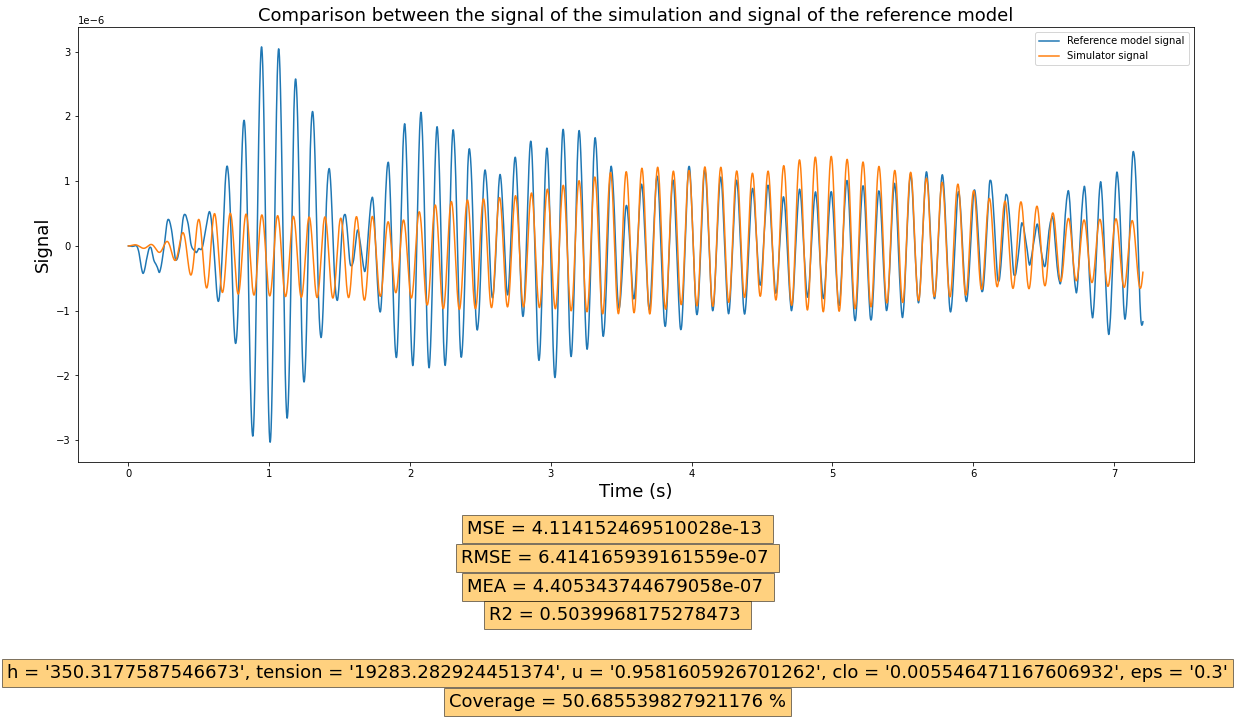

In [6]:
generate_ts(u = 0.9581605926701262,h = 350.3177587546673,
                       tension = 19283.282924451374,clo = 0.005546471167606932,
                      LIST_PATH  = LIST_PATH_1,TS_INDEX = 0)